In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import box, Point, LineString, MultiLineString
import os
import osmnx as ox
import random
import numpy as np
import math

In [2]:
rail_file_path="C:\\Users\\revueltaap\\UNICAN\\EMCAN 2024 A2 ADAPTA - Documentos\\02_Tareas\\Proyecto redes\\DATABASES\\euro-regional-map-shp\\FullEurope\\data\\RailrdL.shp"
rail_stops_file_path="C:\\Users\\revueltaap\\UNICAN\\EMCAN 2024 A2 ADAPTA - Documentos\\02_Tareas\\Proyecto redes\\DATABASES\\euro-regional-map-shp\\FullEurope\\data\\RailrdC.shp"

gdf_cut = ox.geocode_to_gdf("Haute-Corse, Francia")
gdf_cut = gdf_cut.to_crs(epsg=4258)

In [3]:
gdf_rail = gpd.read_file(rail_file_path)
gdf_rail = gpd.clip(gdf_rail, gdf_cut)

gdf_rail_stops=gpd.read_file(rail_stops_file_path)
gdf_rail_stops=gpd.clip(gdf_rail_stops, gdf_cut)

In [4]:
'Unir lines'
# 1. Asegurarse de que todas las geometrías son LineString
def explode_multilines(gdf):
    out = []
    for idx, geom in gdf.geometry.items():
        if isinstance(geom, LineString):
            out.append(geom)
        elif isinstance(geom, MultiLineString):
            out.extend(list(geom.geoms))
    return gpd.GeoDataFrame(geometry=out, crs=gdf.crs)

gdf_lines = explode_multilines(gdf_rail)

# 2. Construir grafo topológico de los tramos
G = nx.Graph()
for i, line in enumerate(gdf_lines.geometry):
    coords = list(line.coords)
    for j in range(len(coords) - 1):
        p1, p2 = coords[j], coords[j+1]
        G.add_edge(p1, p2, line_id=i)

# 3. Encontrar cadenas lineales (secuencias con nodos intermedios de grado=2)
def find_chains(G):
    visited_edges = set()
    chains = []

    for u, v in G.edges():
        if (u, v) in visited_edges or (v, u) in visited_edges:
            continue

        chain = [u, v]
        visited_edges.add((u, v))
        visited_edges.add((v, u))

        # expandir hacia u
        current = u
        prev = v
        while G.degree[current] == 2:
            neighbors = [n for n in G.neighbors(current) if n != prev]
            if not neighbors:
                break
            nxt = neighbors[0]
            chain.insert(0, nxt)
            visited_edges.add((current, nxt))
            visited_edges.add((nxt, current))
            prev, current = current, nxt

        # expandir hacia v
        current = v
        prev = u
        while G.degree[current] == 2:
            neighbors = [n for n in G.neighbors(current) if n != prev]
            if not neighbors:
                break
            nxt = neighbors[0]
            chain.append(nxt)
            visited_edges.add((current, nxt))
            visited_edges.add((nxt, current))
            prev, current = current, nxt

        chains.append(chain)

    return chains

chains = find_chains(G)

# 4. Crear nuevas LineString fusionadas
merged_lines = [LineString(chain) for chain in chains]

gdf_rail = gpd.GeoDataFrame(geometry=merged_lines, crs=gdf_lines.crs)

#gdf_rail.to_file("vias_fusionadas.shp")

In [ ]:
'Plotear con lines unidas'
gdf_rail = gdf_rail.reset_index(drop=True)   # por si acaso limpiar el índice
gdf_rail["id"] = gdf_rail.index              # usar el índice como id
ax = gdf_rail.plot(
    column="id",
    cmap="tab20",
    linewidth=2,
    legend=True,
    figsize=(10, 8)
)

plt.show()

In [5]:
'Plotar gdfs'
fig, ax = plt.subplots(figsize=(10, 8))
gdf_cut.plot(ax=ax,color="lightgrey", edgecolor="black", figsize=(8, 8))
gdf_rail.plot(ax=ax, color="green", edgecolor="black",linewidth=0.5)
gdf_rail_stops.plot(ax=ax, color="red",markersize=0.5)

plt.savefig("mapa.png", dpi=300, bbox_inches="tight")
plt.close()
os.startfile("mapa.png")

In [6]:
'GDF to NX_GRAPH'

G = nx.MultiGraph()   # <--- Multigraph en vez de Graph

# Añadir nodos de estaciones
for idx, est in gdf_rail_stops.iterrows():
    G.add_node(idx, **est.to_dict(), type="station")

# Diccionario para localizar nodos por coordenadas (tuplas)
coord_to_node = {tuple(est.geometry.coords[0]): idx for idx, est in gdf_rail_stops.iterrows()}

# Contador para nodos nuevos
cross_id = 0

# Procesar cada vía
for i, via in gdf_rail.iterrows():
    estaciones_conectadas = gdf_rail_stops[gdf_rail_stops.intersects(via.geometry)].copy()

    # --- Nodo inicial ---
    line_start = tuple(via.geometry.coords[0])
    if line_start in coord_to_node:
        start_node = coord_to_node[line_start]
    else:
        start_node = f"start_{cross_id}"
        G.add_node(start_node, geometry=Point(line_start), type="start")
        coord_to_node[line_start] = start_node
        cross_id += 1

    # --- Nodo final ---
    line_end = tuple(via.geometry.coords[-1])
    if line_end in coord_to_node:
        end_node = coord_to_node[line_end]
    else:
        end_node = f"end_{cross_id}"
        G.add_node(end_node, geometry=Point(line_end), type="end")
        coord_to_node[line_end] = end_node
        cross_id += 1

    if len(estaciones_conectadas) >= 1:
        # Ordenar estaciones según la proyección sobre la línea
        estaciones_conectadas["pos"] = estaciones_conectadas.geometry.apply(
            lambda p: via.geometry.project(p)
        )
        estaciones_ordenadas = estaciones_conectadas.sort_values("pos").index.tolist()

        # Conectar estaciones consecutivas
        for j in range(len(estaciones_ordenadas) - 1):
            n1 = estaciones_ordenadas[j]
            n2 = estaciones_ordenadas[j + 1]
            G.add_edge(n1, n2, via_id=i)

        # Conectar primera estación con nodo inicial
        G.add_edge(start_node, estaciones_ordenadas[0], via_id=i)
        # Conectar última estación con nodo final
        G.add_edge(estaciones_ordenadas[-1], end_node, via_id=i)
    else:
        # Si no hay estaciones, conectar directamente inicio y fin
        G.add_edge(start_node, end_node, via_id=i)


In [ ]:
'Plotear NX_GRAPH con nodos intermedios'
fig, ax = plt.subplots(figsize=(10, 8))
gdf_cut.plot(ax=ax, color="lightgrey", edgecolor="black")

pos = {n: (G.nodes[n]['geometry'].x, G.nodes[n]['geometry'].y) for n in G.nodes()}
nx.draw(G, pos,node_size=0.1,width=0.1, node_color="red",edge_color="green", with_labels=False,ax=ax
)

# Guardar imagen
plt.savefig("grafo_nx.png", dpi=1200, bbox_inches="tight")
plt.close()
os.startfile("grafo_nx.png")

In [ ]:
    # Lista de nodos a procesar
nodes_to_collapse = [n for n, d in G.degree() if d > 2]

for n in nodes_to_collapse:
    neighbors = list(G.neighbors(n))

    # Conectar todos los vecinos entre sí
    for i in range(len(neighbors)):
        for j in range(i + 1, len(neighbors)):
            if not G.has_edge(neighbors[i], neighbors[j]):
                # Tomamos el via_id más común, o se puede dejar vacío
                # Aquí dejamos via_id como lista de los via_id originales
                via_ids = []
                if G.has_edge(n, neighbors[i]):
                    via_ids.append(G[n][neighbors[i]].get('via_id'))
                if G.has_edge(n, neighbors[j]):
                    via_ids.append(G[n][neighbors[j]].get('via_id'))

                G.add_edge(neighbors[i], neighbors[j], via_id=via_ids)

    # Eliminar el nodo central
    G.remove_node(n)


In [7]:
# --- Eliminar componentes conexas de solo 2 nodos ---
for comp in list(nx.connected_components(G)):
    if len(comp) == 2:  # es solo una arista
        G.remove_nodes_from(comp)

In [8]:
G.remove_edges_from(nx.selfloop_edges(G))

In [ ]:
'Plotear NX_GRAPH'
fig, ax = plt.subplots(figsize=(10, 8))
gdf_cut.plot(ax=ax, color="lightgrey", edgecolor="black")

pos = {n: (G.nodes[n]['geometry'].x, G.nodes[n]['geometry'].y) for n in G.nodes()}
nx.draw(G, pos,node_size=0.1,width=0.1, node_color="red",edge_color="green", with_labels=False,ax=ax
)

# Guardar imagen
plt.savefig("grafo_nx.png", dpi=300, bbox_inches="tight")
plt.close()
os.startfile("grafo_nx.png")

In [ ]:
'''Plotear nx abstracto'''
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, seed=42)   # layout abstracto
nx.draw(
    G, pos,
    node_size=0.5,
    width=0.5,
    node_color='red',
    edge_color='blue',
    with_labels=False,
    ax=ax
)
# Guardar imagen
plt.savefig("grafo_nx_abs.png", dpi=300, bbox_inches="tight")
plt.close()
os.startfile("grafo_nx_abs.png")

In [11]:
'NX to I_GRAPH'

# 1️⃣ Lista de nodos y mapeo a índices
nodes = list(G.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}

# 2️⃣ Extraer todas las aristas (incluidas paralelas) y atributos
edges = []
edges_attrs = []
for u, v, key, attr in G.edges(keys=True, data=True):
    edges.append((node_to_idx[u], node_to_idx[v]))
    edges_attrs.append(attr.copy())  # copiar el diccionario de atributos

# 3️⃣ Crear grafo igraph (duplicados de edges se mantienen automáticamente)
g_ig = ig.Graph(edges=edges, directed=False)

# 4️⃣ Añadir atributos de nodos
for n, idx in node_to_idx.items():
    g_ig.vs[idx]["name"] = 'railway '+str(n)  # opcional: nombre original del nodo
    for k, v in G.nodes[n].items():
        g_ig.vs[idx][k] = v

# 5️⃣ Añadir atributos de aristas
for e_idx, attr in enumerate(edges_attrs):
    for k, v in attr.items():
        g_ig.es[e_idx][k] = v

In [16]:
#Prueba de asignación de flujos

# -------------------------------
# Usuarios por nodo
# -------------------------------
g=g_ig
g.vs["users"] = [random.randint(50, 200) for _ in g.vs]

# -------------------------------
# Inicializar flujos de salida por aristas
# -------------------------------

shares_by_node = {v["name"]: {} for v in g.vs}

# Asignar porcentajes de salida a las aristas (sum ≤ 1)
for v in g.vs:
    neighbors = g.neighbors(v, mode="ALL")
    if not neighbors:
        continue

    weights = [random.random() for _ in neighbors]
    total = sum(weights)
    factor = random.uniform(0.5, 0.9)  # suma de salidas ≤1
    shares = [round((w/total) * factor, 2) for w in weights]

    for n, s in zip(neighbors, shares):
        shares_by_node[v["name"]][g.vs[n]["name"]] = s

# Asignar atributos a las aristas
for e in g.es:
    u_name, v_name = g.vs[e.source]["name"], g.vs[e.target]["name"]
    e[u_name] = shares_by_node[u_name].get(v_name)
    e[v_name] = shares_by_node[v_name].get(u_name)

# -------------------------------
# Calcular flujo de llegada
# -------------------------------

for v in g.vs:
    name = v["name"]
    incoming_flows = []
    total_incoming = 0

    # Recoger todos los flujos entrantes
    for e in g.es:
        u_name, w_name = g.vs[e.source]["name"], g.vs[e.target]["name"]
        if w_name == name:  # flujo desde u hacia v
            flow_value = e[u_name] * g.vs[e.source]["users"]
            incoming_flows.append((e, "source", flow_value))
            total_incoming += flow_value
        elif u_name == name:  # flujo desde w hacia v
            flow_value = e[w_name] * g.vs[e.target]["users"]
            incoming_flows.append((e, "target", flow_value))
            total_incoming += flow_value

    # Escalar flujos si exceden users
    if total_incoming > v["users"]:
        factor = v["users"] / total_incoming
        for e, attr, _ in incoming_flows:
            u_name, v_name = g.vs[e.source]["name"], g.vs[e.target]["name"]
            if attr == "source":
                e[u_name] *= factor
            else:
                e[v_name] *= factor

In [36]:
target_name = "railway end_1"
g=g_ig
# Obtener el nodo
v = g.vs.find(name=target_name)

# Mostrar número de usuarios del nodo
print(f"Nodo {v['name']} tiene {v['users']} usuarios")

# Calcular flujo entrante desde vecinos
incoming_flow = 0
for e in g.es:
    u_name, w_name = g.vs[e.source]["name"], g.vs[e.target]["name"]

    if w_name == target_name:  # flujo desde u -> v
        flow_value = e[u_name] * g.vs[e.source]["users"]
        incoming_flow += flow_value
    elif u_name == target_name:  # flujo desde w -> v
        flow_value = e[w_name] * g.vs[e.target]["users"]
        incoming_flow += flow_value

print(f"Flujo total que llega a {v['name']} desde vecinos: {incoming_flow:.2f}")

Nodo railway end_1 tiene 62 usuarios
Flujo total que llega a railway end_1 desde vecinos: 27.36


In [13]:
# Extraer coordenadas de los nodos
x_coords = [v['geometry'].x for v in g_ig.vs]
y_coords = [v['geometry'].y for v in g_ig.vs]

# Crear layout como lista de pares (x, y)
coords_layout = list(zip(x_coords, y_coords))


g_ig = g_ig.simplify(combine_edges=None)

fig, ax = plt.subplots(figsize=(10, 8))
ig.plot(
    g_ig,
    target=ax,
    layout=coords_layout,  # <-- usamos las coordenadas reales
    vertex_size=10,
    vertex_color='red',
    edge_color='blue',
    edge_width=1,
    vertex_label=g_ig.vs["name"],
    margin=20
)
gdf_cut.plot(ax=ax, facecolor="none", edgecolor="black")
xmin, ymin, xmax, ymax = gdf_cut.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.savefig("grafo_ig_geo.png", dpi=300, bbox_inches="tight")
plt.close()
os.startfile("grafo_ig_geo.png")

In [ ]:
# Nombres de los nodos que quieres mostrar
nodos_objetivo = ["26650", "26649", "26651"]

# Filtrar vértices por nombre
indices_objetivo = [v.index for v in g_ig.vs if v["name"] in failed_vertex_list]

# Crear subgrafo solo con esos nodos
g_sub = g_ig.subgraph(indices_objetivo)

# Extraer coordenadas de los nodos seleccionados
x_coords = [v['geometry'].x for v in g_sub.vs]
y_coords = [v['geometry'].y for v in g_sub.vs]
coords_layout = list(zip(x_coords, y_coords))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ig.plot(
    g_sub,
    target=ax,
    layout=coords_layout,
    vertex_size=20,
    vertex_color="red",
    edge_color="blue",
    edge_width=1,
    vertex_label=g_sub.vs["name"],
    vertex_label_size=5,
    margin=20
)

# Plot del recorte base
gdf_cut.plot(ax=ax, facecolor="none", edgecolor="black")

xmin, ymin, xmax, ymax = gdf_cut.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.savefig("grafo_sub.png", dpi=300, bbox_inches="tight")
plt.close()
os.startfile("grafo_sub.png")


In [14]:
layout = g_ig.layout("fr")  # "fr" = Fruchterman-Reingold, similar a nx.spring_layout

# 2️⃣ Dibujar el grafo
fig, ax = plt.subplots(figsize=(10, 8))
g_ig.vs["label"] = [f"{v['name']} ({v['users']})" for v in g_ig.vs]
ig.plot(
    g_ig,
    target=ax,           # dibujar sobre matplotlib
    layout=layout,       # layout abstracto
    vertex_size=1,
    edge_width=0.5,# tamaño de los nodos
    vertex_color='red',  # color de nodos
    edge_color='blue',   # color de aristas
    vertex_label=g_ig.vs["label"],# sin etiquetas
    vertex_label_size=3,
    bbox=(1000, 800),    # tamaño de la imagen en pixeles
    margin=20
)

# 3️⃣ Guardar imagen usando matplotlib
plt.savefig("grafo_ig_abs.png", dpi=600, bbox_inches="tight")
plt.close()
os.startfile("grafo_ig_abs.png")

In [37]:

"""
Dibuja un grafo no dirigido mostrando flechas simuladas desde cada nodo
para indicar el flujo que sale por cada arista.
Cada arista tiene dos atributos: flujo desde cada nodo.
"""

# Extraer coordenadas
'''x_coords = [v['geometry'].x for v in g_ig.vs]
y_coords = [v['geometry'].y for v in g_ig.vs]
coords_layout = list(zip(x_coords, y_coords))'''
layout = g_ig.layout("kk")
coords_layout = [(x, y) for x, y in layout.coords]
x_coords = [c[0] for c in coords_layout]
y_coords = [c[1] for c in coords_layout]

# Creamos listas para flechas y etiquetas
arrows = []
edge_labels = []
edge_widths = []

for e in g_ig.es:
    u_idx, v_idx = e.source, e.target
    u_name = str(g_ig.vs[u_idx]["name"])
    v_name = str(g_ig.vs[v_idx]["name"])

    # Flujo desde cada nodo
    flow_u = e[u_name]
    flow_v = e[v_name]

    # Simulamos flecha desde u a v
    arrows.append(((coords_layout[u_idx], coords_layout[v_idx]), flow_u))
    # Simulamos flecha desde v a u
    arrows.append(((coords_layout[v_idx], coords_layout[u_idx]), flow_v))

# Plot con matplotlib
fig, ax = plt.subplots(figsize=(12,10))
ax.set_aspect('equal')
ax.set_title("Flujos de nodos")

# Dibujar nodos
ax.scatter(x_coords, y_coords, s=5, c='red', zorder=3)
for i, v in enumerate(g_ig.vs):
    ax.text(
        x_coords[i],
        y_coords[i],
         f"{v['name']}\n({v['users']})",  # Texto: nombre (usuarios)
        fontsize=1,
        color="black",        # Contrasta mejor con el nodo rojo
        ha="center",          # Centrado horizontal
        va="center",          # Centrado vertical
        zorder=4,
    )


# Dibujar flechas y etiquetas
for (start, end), flow in arrows:
    # Dibujar la flecha
    ax.annotate(
        "", xy=end, xytext=start,
        arrowprops=dict(arrowstyle="->", color='blue', lw=0.8),
        zorder=2
    )

    # Vector de la arista
    dx = end[0] - start[0]
    dy = end[1] - start[1]
    length = (dx**2 + dy**2)**0.5

    # Posición del texto: cerca del inicio, a un 15% de la arista
    t = 0.15
    x_text = start[0] + t * dx
    y_text = start[1] + t * dy

    # Desplazamiento perpendicular opcional para evitar solapamientos
    perp_offset = 0.02 * length
    x_text += -perp_offset * dy / length
    y_text += perp_offset * dx / length

    # Dibujar la etiqueta
    ax.text(x_text, y_text, f"{flow:.2f}",
            fontsize=1, color='black', zorder=4,
            ha='center', va='center')

'''gdf_cut.plot(ax=ax, facecolor="none", edgecolor="black")
xmin, ymin, xmax, ymax = gdf_cut.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)'''
plt.savefig("grafo_ig_flujo.png", dpi=1200, bbox_inches="tight")
plt.close()
os.startfile("grafo_ig_flujo.png")

In [38]:
'''Simulador de fallo del sistema de varios elementos a la vez'''
def simulate_scenario(a_f_list,t_0,g_ig,params_dic, dt, fail_drop):
    scenario_dic={}
    total_users=0
    for v in g_ig.vs:
        scenario_dic[v['name']]=[v['users']]
        total_users+=v['users']
    #print(a_f['name'],total_users)
    state_flag='initial'
    t=dt
    while state_flag!='finished':
        actual_users=0
        t_ref = np.maximum(dt, round(t - params_dic['tFa'],1))
        index = int(round(t_ref / dt)) - 1
        for v in g_ig.vs:
            neighbors_list = g_ig.vs[g_ig.neighbors(v)]
            node_users = v['users']
            for u in neighbors_list:
                e=g_ig.es[g_ig.get_eid(u.index, v.index)]
                if v['name']== 'railway end_1':
                    print(e[v['name']])
                reference_value=scenario_dic[u['name']][index]
                node_users=node_users-(u['users']-reference_value)*e[u['name']]
            if v in a_f_list:
                capacity_profile=asset_failure_profile(t,v['users'],t_0,fail_drop,params_dic)
                if node_users>capacity_profile:
                    node_users=capacity_profile
            #print(node_users)
            scenario_dic[v['name']].append(node_users)
            actual_users+=node_users

        if actual_users<total_users:
            state_flag='failure'

        if state_flag == 'failure' and abs(actual_users - total_users) < 0.1:
            state_flag='finished'
        #print(actual_users,t,state_flag)
        t=round(t+dt,1)
    return scenario_dic

def asset_failure_profile(t,initial_value,t_f,fail_drop,params_dic):
    if t<t_f+params_dic['tFa']:
        return initial_value
    elif t_f+params_dic['tFa']<=t<t_f+params_dic['tFa']+params_dic['Rc0']+params_dic['tRc']:
        return initial_value*(1-fail_drop)
    else:
        return initial_value

In [39]:
'Simulador de fallos de 1 elemento'

fail_drop=1.0 #Total
t_0=1.0
params_dic={'tFa':1.0,'Rc0':1.0,'tRc':4.0}
dt=0.1 #(h)

scenarios_dic={}
for v_f in g_ig.vs:
    scenarios_dic[v_f["name"]]= simulate_scenario([v_f],t_0,g_ig,params_dic, dt, fail_drop)
#for e_f in g_ig.es:
 #   scenarios_dic[e_f.index]= simulate_scenario([e_f],t_0,g_ig,params_dic, dt, fail_drop)

0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


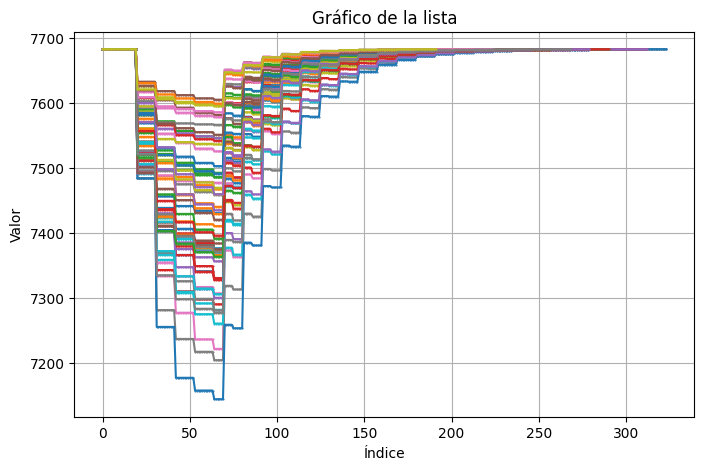

In [26]:
plt.figure(figsize=(8,5))
for node,dic in scenarios_dic.items():
    lista=[sum(x) for x in zip(*dic.values())]
    x = list(range(len(lista)))
    plt.plot(x, lista, marker='.',markersize=1,label=node)  # gráfica de línea con puntos
    #plt.text(x[-1] + 0.1, lista[-1], node, va="center")
plt.title("Gráfico de la lista")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

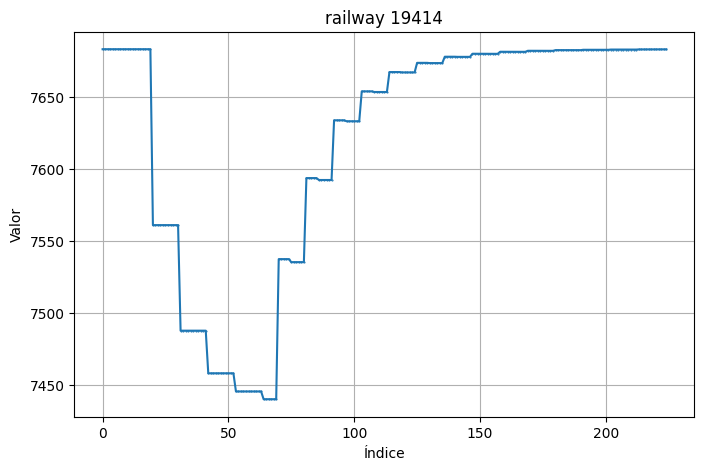

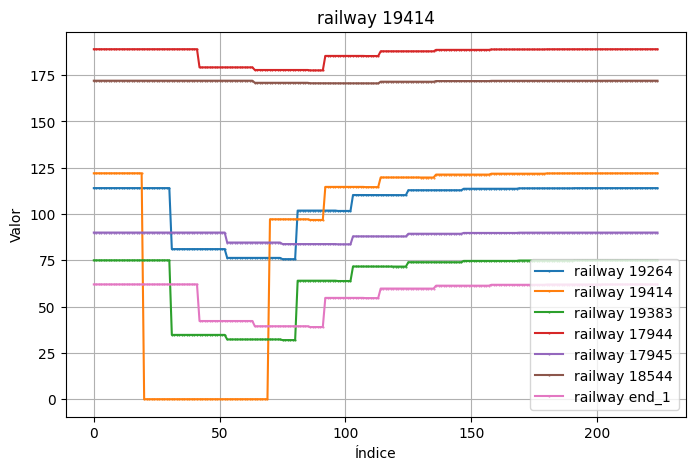

In [21]:
failed_asset = list(scenarios_dic.keys())[1]

plt.figure(figsize=(8,5))
lista=[sum(x) for x in zip(*scenarios_dic[failed_asset].values())]
x = list(range(len(lista)))
plt.plot(x, lista, marker='.',markersize=1,label=node)  # gráfica de línea con puntos
#plt.text(x[-1] + 0.1, lista[-1], node, va="center")
plt.title(failed_asset)
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))

for node, lista in scenarios_dic[failed_asset].items():
    # Solo plotear si hay algún cambio en la lista
    if max(lista) - lista[0] > 1 or lista[0] - min(lista) > 1:
        x = list(range(len(lista)))
        plt.plot(x, lista, marker='.', markersize=1, label=node)
plt.title(failed_asset)
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.grid(True)
plt.legend()
plt.show()

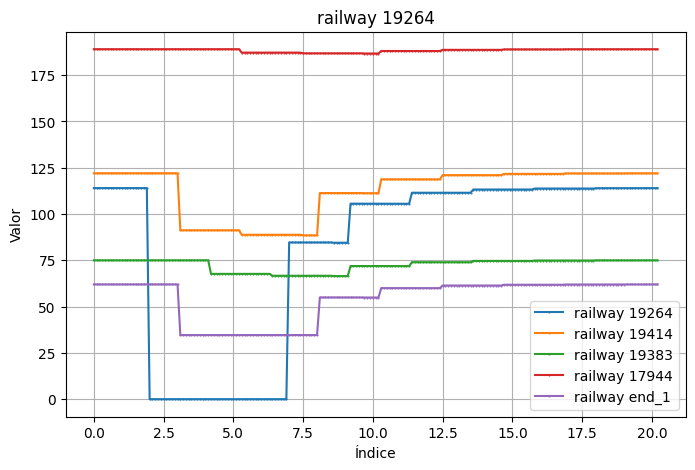

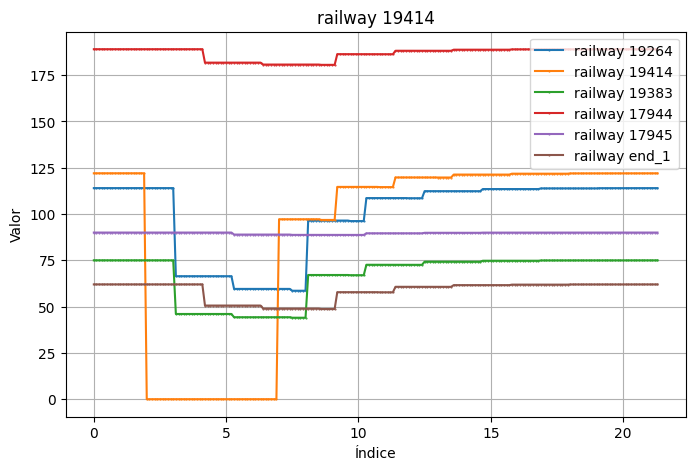

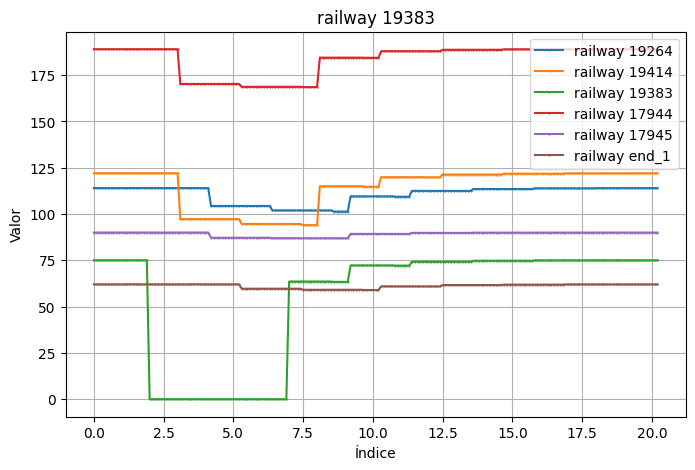

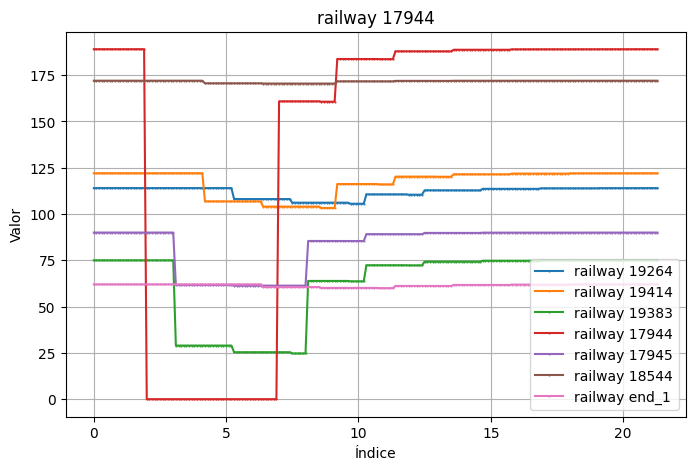

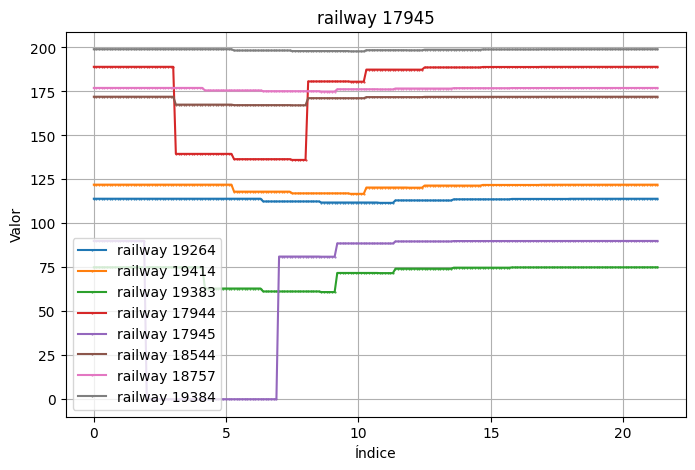

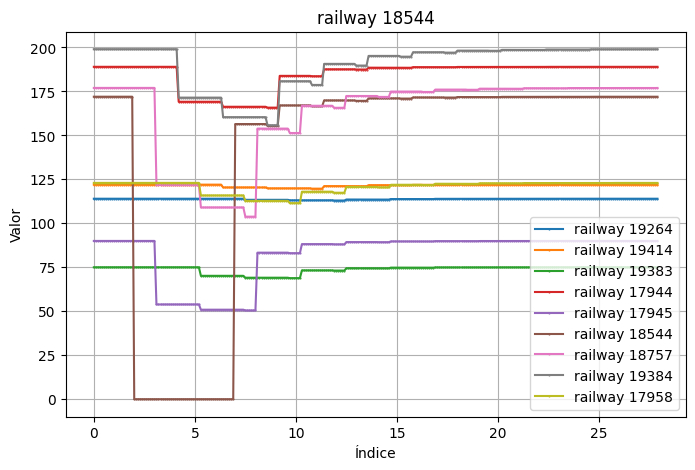

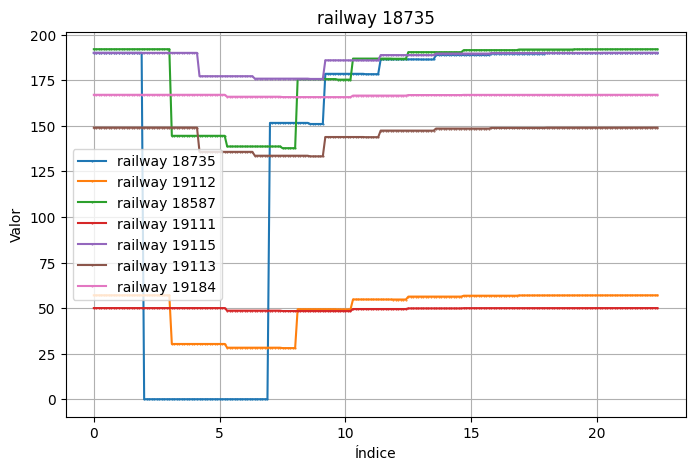

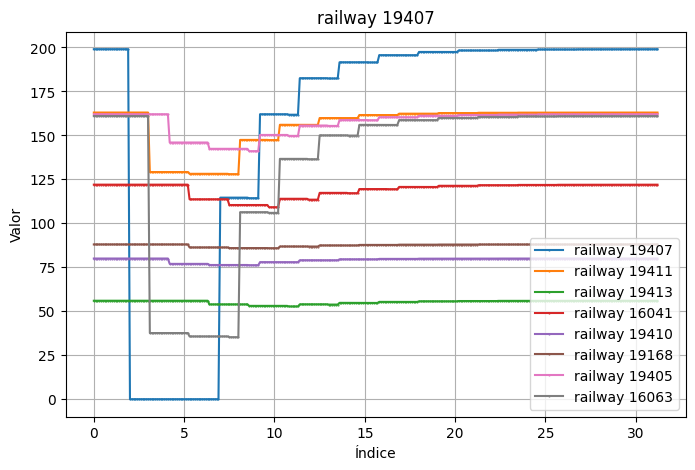

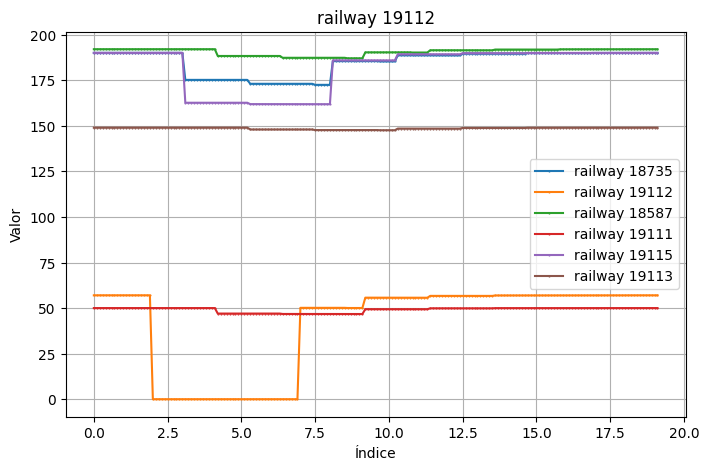

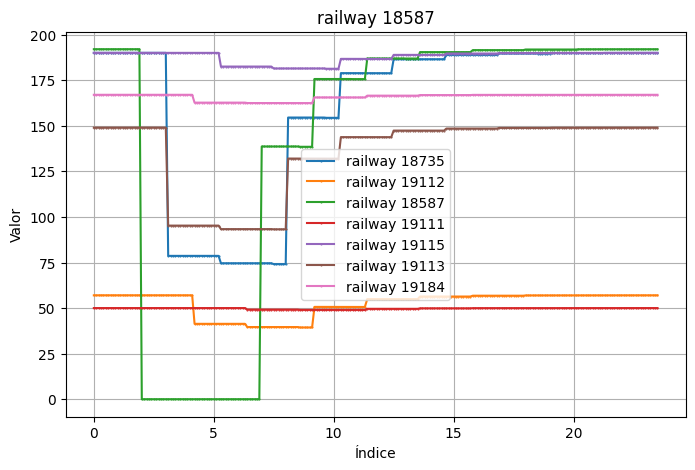

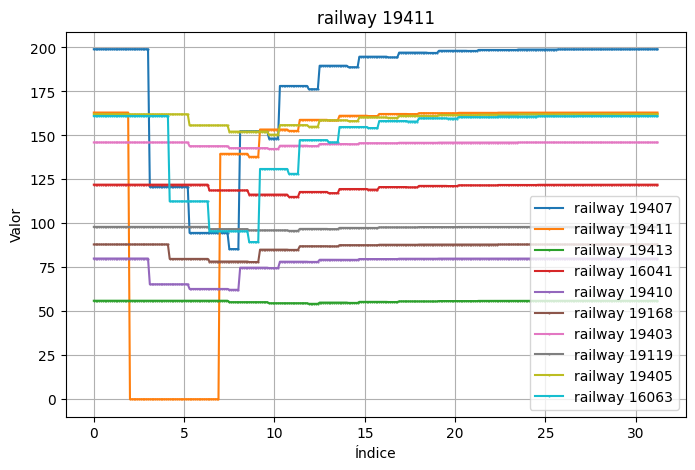

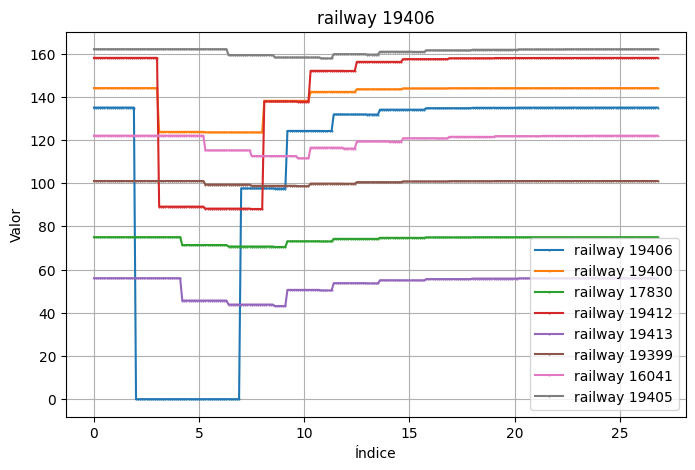

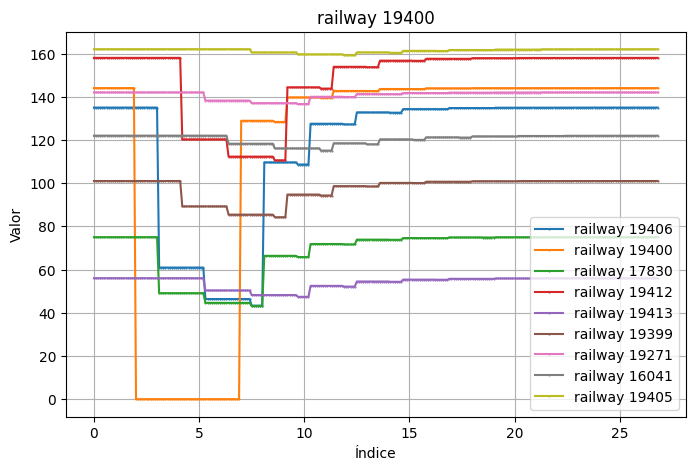

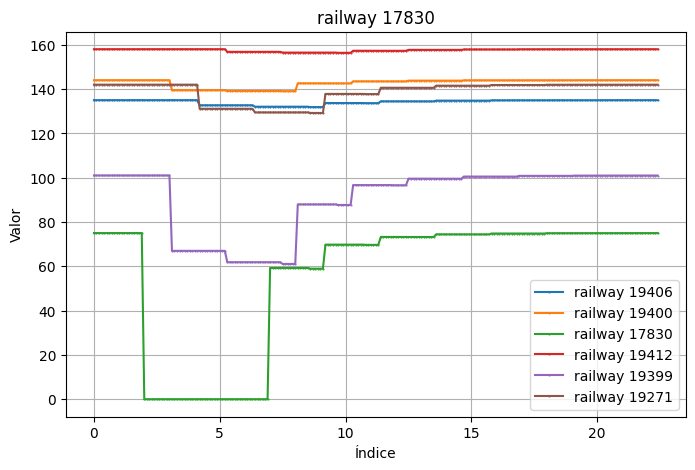

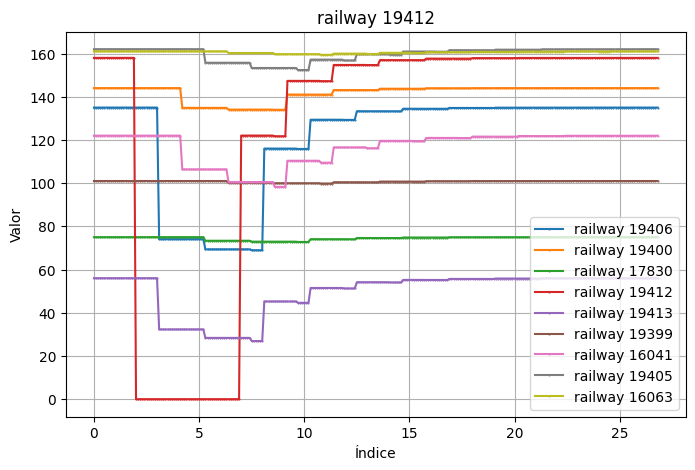

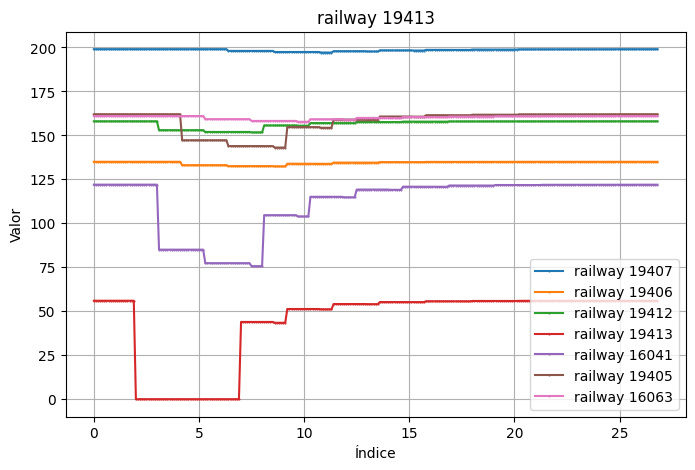

KeyboardInterrupt: 

In [40]:
for node,dic in scenarios_dic.items():
    plt.figure(figsize=(8,5))
    for nodes, lista in scenarios_dic[node].items():
        # Solo plotear si hay algún cambio en la lista
        if max(lista) - lista[0] > 1 or lista[0] - min(lista) > 1:
            x = [i*0.1 for i in range(len(lista))]
            plt.plot(x, lista, marker='.', markersize=1, label=nodes)
    plt.title(node)
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.legend()
    plt.show()